# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `data/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by `clean.ipynb`
* `data/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `data/us_counties_curves.csv`: The curves that this notebook generated
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`


In [1]:
# Initialization boilerplate

# Ensure a consistent Python environment.
import sys
sys.path.append("..")  # Local libraries are in the directory above "notebooks"
import env
env.maybe_install_libs()

import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = "../data/us_counties_clean.csv"
meta_file = "../data/us_counties_clean_meta.json"

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   
      2020-04-26  Wyoming   Weston        6927          0       0          0   
      2020-04-27  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-04-23              False           False              False  
      2020-04-24              False           False              False  
      2020-04-25              False           False              False  
      2020-04-26              False           False              False  
      2020-04-27              False           False              False  

[304774 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   
      2020-04-26  Wyoming   Weston        6927          0       0          0   
      2020-04-27  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-04-23                  0               0                  0  
      2020-04-24                  0               0                  0  
      2020-04-25                  0               0                  0  
      2020-04-26                  0               0                  0  
      2020-04-27                  0               0                  0  

[304774 rows x 9 columns]

In [4]:
# Use Text Extensions for Pandas to collapse each time series or mask down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

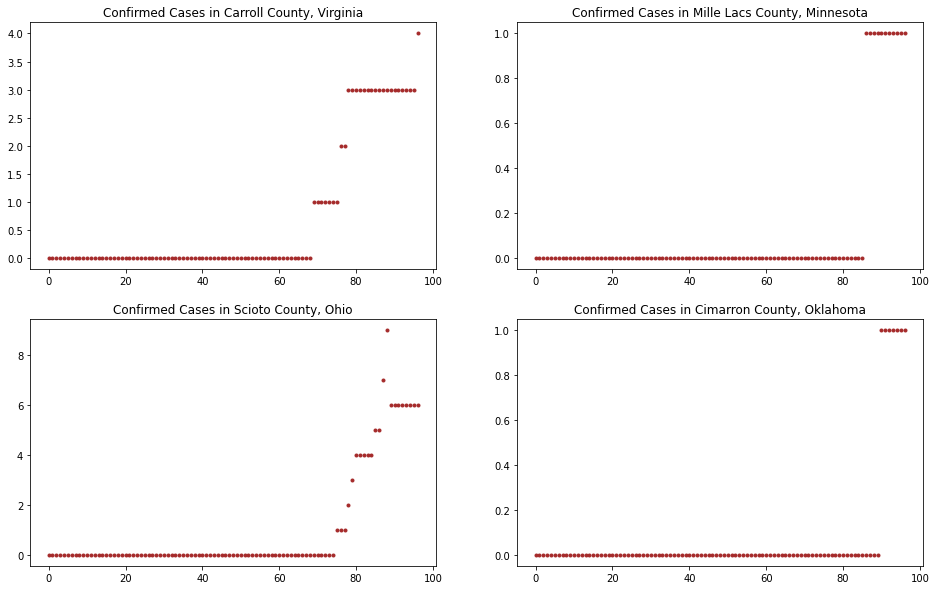

In [6]:
# Because these time series are integer-valued, there can be
# problems with aliasing. 
# Here are some examples of what aliasing looks like:
# (graph_examples() function defined in util.py)
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].values, axis=1) < 10))

In [7]:
# To avoid problems due to aliasing, we will restrict the analysis
# in the rest of this notebook to time series whose maximum values
# go above a threshold:
alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].values, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].values, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].values[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].values[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [8]:
# Warm-up: Fit a straight line.
# We use sklearn's implementation of BGFS as the optimizer.

# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].values.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 16405.87102041453, 'jac': [0.0, 0.0], ...",3.511021,-35.019614,[-3.50196143e+01 -3.15085932e+01 -2.79975721e+0...,0.880435
1017,Alabama,Chambers,33254,"{'fun': 54377.31958762886, 'jac': [0.000727595...",6.772459,-49.000000,[-49. -42.2275405 -35.455081 -28.682...,0.906075
1055,Alabama,Etowah,102268,"{'fun': 11218.426122449408, 'jac': [0.00018189...",3.023673,-30.527341,[-30.52734113 -27.50366784 -24.47999455 -21.456...,0.888724
1073,Alabama,Jefferson,658573,"{'fun': 128628.01756785187, 'jac': [0.0, 1604....",17.921891,-49.000000,[-49. -31.07810857 -13.15621713 4.765...,0.967463
1081,Alabama,Lee,164542,"{'fun': 57975.257705659584, 'jac': [0.0, 570.9...",8.203635,-49.000000,[-4.90000000e+01 -4.07963654e+01 -3.25927309e+0...,0.930004
...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,"{'fun': 16254.636326531614, 'jac': [-0.0001818...",2.759388,-27.511029,[-2.75110293e+01 -2.47516413e+01 -2.19922533e+0...,0.821130
55127,Wisconsin,Walworth,103868,"{'fun': 17436.05551020523, 'jac': [-0.00036379...",2.610612,-28.450603,[-28.45060271 -25.83999077 -23.22937883 -20.618...,0.792985
55133,Wisconsin,Waukesha,404198,"{'fun': 11388.113877551415, 'jac': [0.00800355...",7.471633,-44.176326,[-44.17632608 -36.70469334 -29.2330606 -21.761...,0.979609


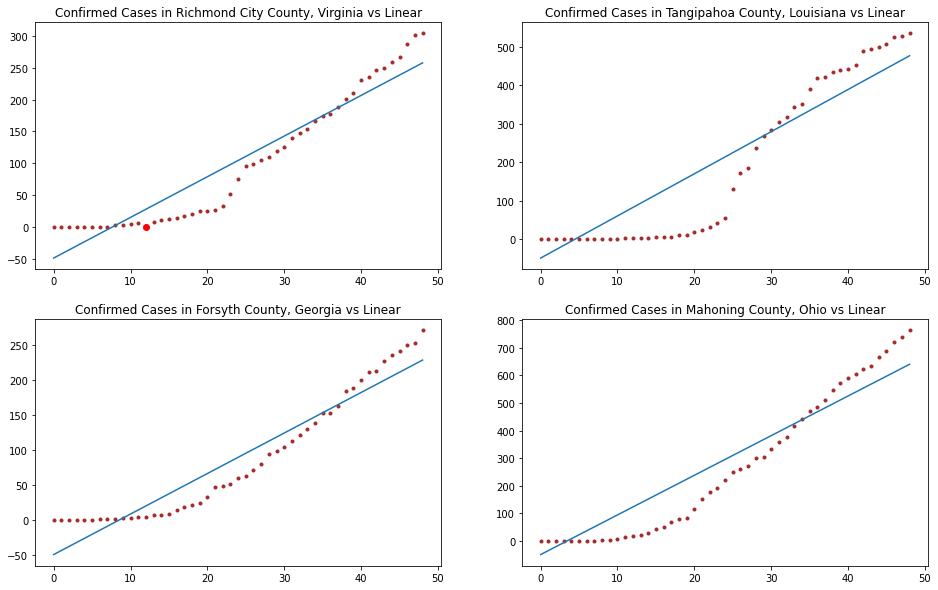

In [9]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

In [10]:
# Now let's fit some more appropriate curves to this data.
# First, break out the repetitive parts of the curve-fitting process into
# a Python function.
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].values.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [11]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate)(X - offset)
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curve sto each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


In [12]:
# Now we can fit those curves.
# First, the exponential curves.
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 17023.9285163527, 'jac': [-0.001455191...",0.111723,0.0,[ 1. 1.11820339 1.25037883 1.398...,0.875931
1017,Alabama,Chambers,33254,"{'fun': 230125.7628655417, 'jac': [0.113504938...",0.126662,0.0,[ 1. 1.1350336 1.28830127 1.462...,0.602510
1055,Alabama,Etowah,102268,"{'fun': 18669.25449689834, 'jac': [0.083673512...",0.107638,0.0,[ 1. 1.11364501 1.24020522 1.381...,0.814818
1073,Alabama,Jefferson,658573,"{'fun': 3461413.019324673, 'jac': [0.512227416...",0.149094,0.0,[1.00000000e+00 1.16078198e+00 1.34741480e+00 1...,0.124412
1081,Alabama,Lee,164542,"{'fun': 387274.23798185016, 'jac': [-0.0291038...",0.131487,0.0,[ 1. 1.14052273 1.30079211 1.483...,0.532425
...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,"{'fun': 5015.53645020392, 'jac': [0.0023646862...",0.107383,0.0,[ 1. 1.11336044 1.23957147 1.380...,0.944808
55127,Wisconsin,Walworth,103868,"{'fun': 2964.5282315084723, 'jac': [-0.0065483...",0.105856,0.0,[ 1. 1.11166181 1.23579198 1.373...,0.964803
55133,Wisconsin,Waukesha,404198,"{'fun': 381994.6445749309, 'jac': [-0.01746229...",0.128105,0.0,[ 1. 1.13667276 1.29202497 1.468...,0.316005


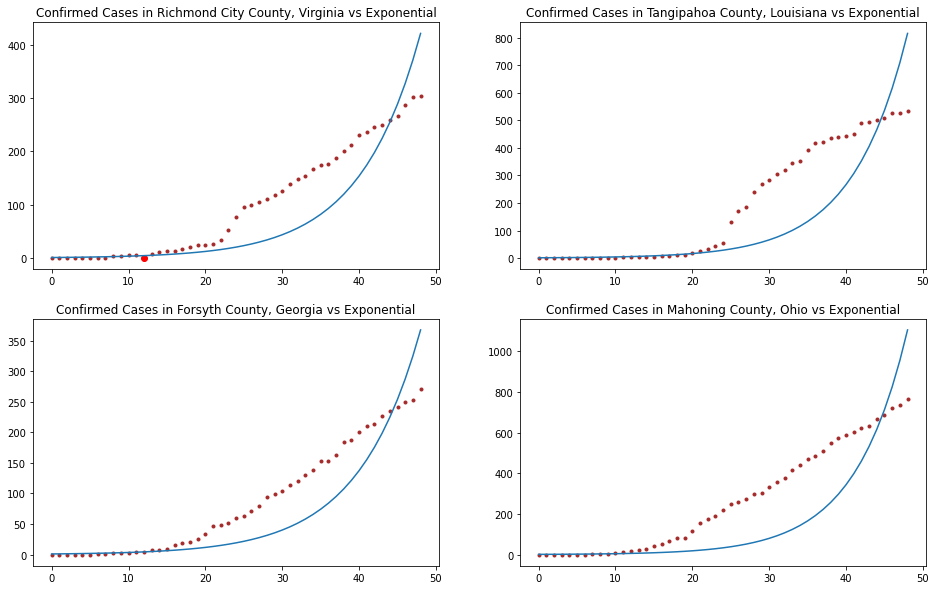

In [13]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

In [14]:
# Then fit the logistic function
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 485.2029725684195, 'jac': [8.526512829...",195.404448,0.142489,37.250851,[ 0.96298939 1.10962475 1.27844161 1.472...,0.996464
1017,Alabama,Chambers,33254,"{'fun': 2299.833706709478, 'jac': [-0.00022737...",288.014155,0.207551,29.944982,[ 0.57459197 0.7068023 0.86934147 1.069...,0.996028
1055,Alabama,Etowah,102268,"{'fun': 938.6043343432573, 'jac': [1.136868377...",128.251876,0.189767,32.369459,[ 0.27505011 0.33237775 0.40161648 0.485...,0.990690
1073,Alabama,Jefferson,658573,"{'fun': 30674.187390586674, 'jac': [0.00145519...",820.322588,0.143348,26.589647,[ 17.74747004 20.41484405 23.47138952 26.970...,0.992241
1081,Alabama,Lee,164542,"{'fun': 4101.914396765344, 'jac': [0.000363797...",384.980633,0.159093,30.688805,[ 2.89579009 3.39076325 3.96946248 4.645...,0.995048
...,...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,"{'fun': 3172.0738574352845, 'jac': [4.54747350...",310.523137,0.107660,49.000000,[ 1.58060615 1.75925448 1.9579666 2.178...,0.965094
55127,Wisconsin,Walworth,103868,"{'fun': 923.2602671917766, 'jac': [-0.00012505...",207.335168,0.140231,43.131623,[ 0.48849613 0.56183498 0.64614994 0.743...,0.989038
55133,Wisconsin,Waukesha,404198,"{'fun': 3445.3091968069243, 'jac': [0.00022737...",310.963542,0.142007,27.114140,[ 6.47690337 7.44152635 8.54578117 9.808...,0.993831


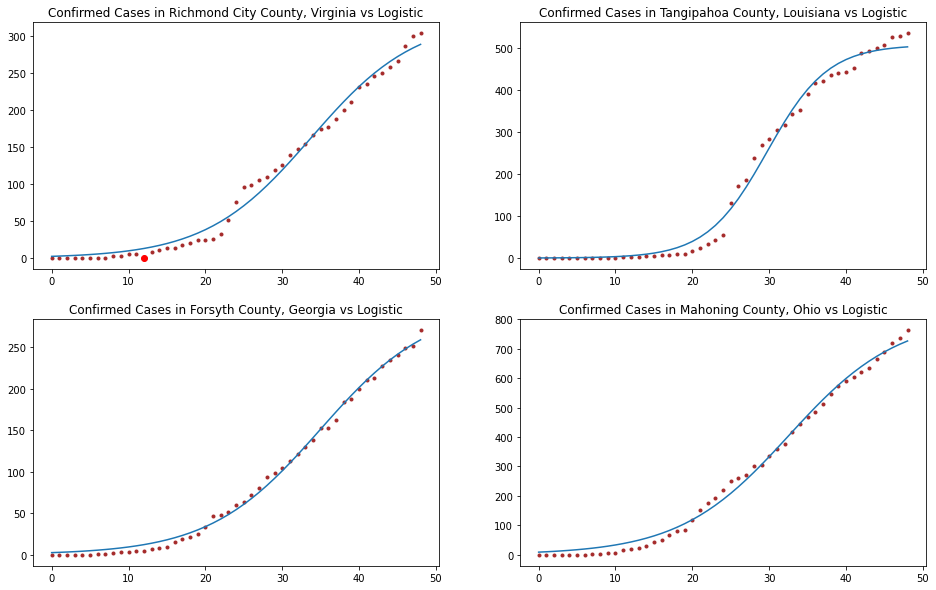

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

In [16]:
# And finally a mixture of two copies of the logistic function
log2_df = fit_logistic2(ts_col_name)
log2_df

,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 225.05779327331447, 'jac': [-0.0268471...",347.705585,0.748706,34.917864,347.057723,0.085263,49.000000,13.278272,18.310386,[1.11235708e-01 1.46883421e-01 1.93739634e-01 2...,0.998360
1017,Alabama,Chambers,33254,"{'fun': 1158.4308584108458, 'jac': [-0.1970647...",326.971064,1.467247,31.159808,329.445360,0.115777,30.546183,15.335094,20.507390,[1.48264120e-01 2.00588714e-01 2.71076091e-01 3...,0.997999
1055,Alabama,Etowah,102268,"{'fun': 209.940471171586, 'jac': [-2.273736754...",1336.551681,9.999576,31.068555,162.031359,0.117815,36.356696,16.233750,18.400513,[7.70855112e-05 1.37349386e-04 2.44672210e-04 4...,0.997918
1073,Alabama,Jefferson,658573,"{'fun': 5311.250560546439, 'jac': [-0.83227860...",1559.753826,1.257055,30.885131,1562.181125,0.047292,45.098611,10.566775,15.008162,[ 3.87768988 5.03629213 6.53021603 8.450...,0.998656
1081,Alabama,Lee,164542,"{'fun': 2594.198605992691, 'jac': [0.101590558...",366.510587,0.273236,23.098836,366.772305,0.193770,30.351929,13.219081,15.172761,[ 0.66418871 0.87239446 1.14566308 1.504...,0.996868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,"{'fun': 350.53933052956444, 'jac': [-0.0001648...",3786.861149,0.956124,46.005326,168.759037,0.013679,48.999944,21.872070,27.294201,[ 0.33246317 0.40294861 0.48824147 0.591...,0.996143
55127,Wisconsin,Walworth,103868,"{'fun': 921.0736170360793, 'jac': [0.007514699...",220.349806,0.157774,44.389438,220.822345,0.128531,44.040176,7.990349,22.448395,[ 0.35586647 0.41834488 0.49146896 0.576...,0.989064
55133,Wisconsin,Waukesha,404198,"{'fun': 482.6358083130111, 'jac': [-0.00123350...",357.368821,10.000000,23.167804,357.160603,0.098802,29.533203,6.713488,10.027113,[ 0.38656627 0.56973451 0.83714343 1.225...,0.999136


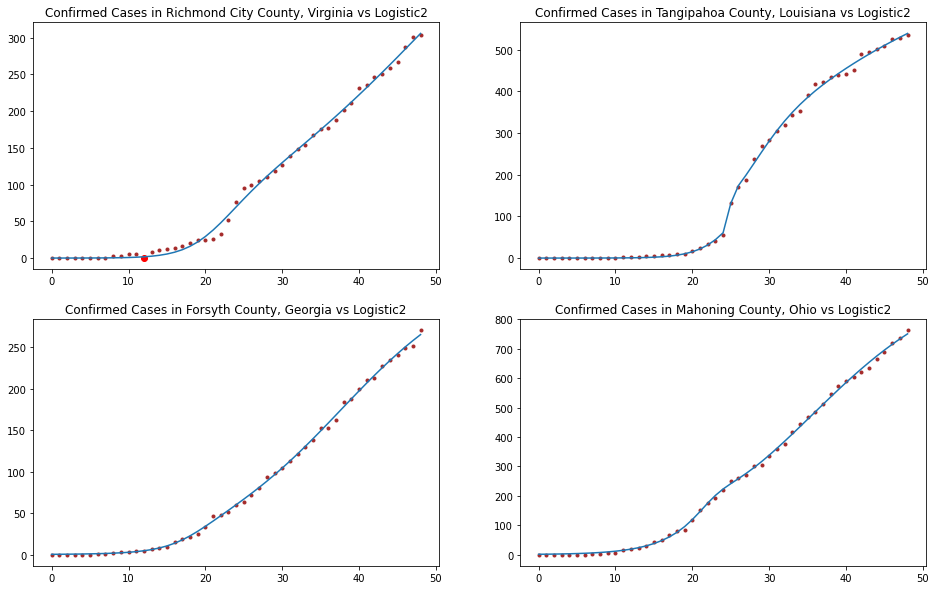

In [17]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

In [18]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11820339 1.25037883 1.398...,[ 0.96298939 1.10962475 1.27844161 1.472...,[1.11235708e-01 1.46883421e-01 1.93739634e-01 2...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.1350336 1.28830127 1.462...,[ 0.57459197 0.7068023 0.86934147 1.069...,[1.48264120e-01 2.00588714e-01 2.71076091e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11364501 1.24020522 1.381...,[ 0.27505011 0.33237775 0.40161648 0.485...,[7.70855112e-05 1.37349386e-04 2.44672210e-04 4...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.16078198e+00 1.34741480e+00 1...,[ 17.74747004 20.41484405 23.47138952 26.970...,[ 3.87768988 5.03629213 6.53021603 8.450...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14052273 1.30079211 1.483...,[ 2.89579009 3.39076325 3.96946248 4.645...,[ 0.66418871 0.87239446 1.14566308 1.504...
...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11336044 1.23957147 1.380...,[ 1.58060615 1.75925448 1.9579666 2.178...,[ 0.33246317 0.40294861 0.48824147 0.591...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11166181 1.23579198 1.373...,[ 0.48849613 0.56183498 0.64614994 0.743...,[ 0.35586647 0.41834488 0.49146896 0.576...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13667276 1.29202497 1.468...,[ 6.47690337 7.44152635 8.54578117 9.808...,[ 0.38656627 0.56973451 0.83714343 1.225...


In [19]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-23  Wyoming  Laramie       99500        117              False   
      2020-04-24  Wyoming  Laramie       99500        120              False   
      2020-04-25  Wyoming  Laramie       99500        124              False   
      2020-04-26  Wyoming  Laramie       99500        125              False   
      2020-04-27  Wyoming  Laramie       99500        128              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.962989    0.111236  
      2020-03-11     1.118203    1.109625    0.146883  
      2020-03-12     1.250379    1.278442    0.193740  
      2020-03-13     1.398178    1.472747    0.255204  
      2020-03-14     1.563447    1.696327    0.335638  
...                       ...         ...         ...  
56021 2020-04-23   108.186079  108.815338  120.583026  
      2020-04-24   120.337933  114.217999  119.201836  
      2020-04-25   133.854728  119.653801  118.473510  
      2020-04-26   148.889778  125.101474  118.301737  
      2020-04-27   165.613620  130.539563  118.603007  

[32389 rows x 8 columns]

In [20]:
# Write out the results to a CSV file plus a JSON file of type metadata.
curves_vertical.to_csv("../data/us_counties_curves.csv", index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}
with open("../data/us_counties_curves_meta.json", "w") as f:
    json.dump(col_type_mapping, f)

In [21]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.111723,0.0,195.404448,0.142489,37.250851,347.705585,0.748706,34.917864,347.057723,0.085263,49.000000,13.278272,18.310386
1017,Alabama,Chambers,33254,0.126662,0.0,288.014155,0.207551,29.944982,326.971064,1.467247,31.159808,329.445360,0.115777,30.546183,15.335094,20.507390
1055,Alabama,Etowah,102268,0.107638,0.0,128.251876,0.189767,32.369459,1336.551681,9.999576,31.068555,162.031359,0.117815,36.356696,16.233750,18.400513
1073,Alabama,Jefferson,658573,0.149094,0.0,820.322588,0.143348,26.589647,1559.753826,1.257055,30.885131,1562.181125,0.047292,45.098611,10.566775,15.008162
1081,Alabama,Lee,164542,0.131487,0.0,384.980633,0.159093,30.688805,366.510587,0.273236,23.098836,366.772305,0.193770,30.351929,13.219081,15.172761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,0.107383,0.0,310.523137,0.107660,49.000000,3786.861149,0.956124,46.005326,168.759037,0.013679,48.999944,21.872070,27.294201
55127,Wisconsin,Walworth,103868,0.105856,0.0,207.335168,0.140231,43.131623,220.349806,0.157774,44.389438,220.822345,0.128531,44.040176,7.990349,22.448395
55133,Wisconsin,Waukesha,404198,0.128105,0.0,310.963542,0.142007,27.114140,357.368821,10.000000,23.167804,357.160603,0.098802,29.533203,6.713488,10.027113


In [22]:
params.to_csv("../data/us_counties_curves_params.csv", index=True)

In [23]:
!ls -lh ../data/us_counties_curves*

-rw-r--r--  1 freiss  staff   3.3M Apr 29 11:34 ../data/us_counties_curves.csv
-rw-r--r--  1 freiss  staff   186B Apr 29 11:34 ../data/us_counties_curves_meta.json
-rw-r--r--  1 freiss  staff   163K Apr 29 11:34 ../data/us_counties_curves_params.csv
